# GA Capstone - Sortify

##### Aziz Maredia | DSIR-1019 | 01.27.21

### Importing Libraries/Packages and Dataframes

In [194]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

In [195]:
album = pd.read_csv('.././datasets/album_to_sort.csv')
tracks = pd.read_csv('.././datasets/combined_tracks.csv')

user_tracks_reg = pd.read_csv('.././datasets/user_tracks_reg.csv')
album_tracks_reg = pd.read_csv('.././datasets/album_tracks_reg.csv')

user_tracks_pca = pd.read_csv('.././datasets/user_tracks_pca.csv')
album_tracks_pca = pd.read_csv('.././datasets/album_tracks_pca.csv')

In [196]:
user_tracks_reg.drop(columns = ['track', 'artist', 'track_id', 'data_type'], inplace = True)
album_tracks_reg.drop(columns = ['track', 'artist', 'track_id', 'data_type'], inplace = True)

user_tracks_pca.drop(columns = ['track', 'artist', 'track_id', 'data_type'], inplace = True)
album_tracks_pca.drop(columns = ['track', 'artist', 'track_id', 'data_type'], inplace = True)

In [197]:
user_tracks_reg.shape

(1524, 66)

In [198]:
album_tracks_reg.shape

(18, 66)

In [199]:
user_tracks_pca.shape

(1524, 8)

In [200]:
album_tracks_pca.shape

(18, 8)

### K-Means Clustering Model

In [201]:
def cluster_user_tracks():
        
    dfs = [('regular', user_tracks_reg), ('pca', user_tracks_pca)]
    results = {'data':[], 'n_clusters':[], 'silhouette_score':[]} # storing results for each df and k value tested
    
    # testing regular data and pca data
    for df in dfs:
        
        X = df[1]
        
        # test values of k from 3 to 12
        for k in range(3,13):
            
            km = KMeans(n_clusters = k, random_state = 42)
            km.fit(X)
            ss = silhouette_score(X, km.labels_)
            
            # saving results to dictionary
            results['data'] = results['data'] + [df[0]]
            results['n_clusters'] = results['n_clusters'] + [k]
            results['silhouette_score'] = results['silhouette_score'] + [ss]
    
    # finding k value with highest score
    optimal_k = results['n_clusters'][results['silhouette_score'].index(max(results['silhouette_score']))]
    
    # figuring out if k value with highest score was with reg or pca data
    if results['data'][results['silhouette_score'].index(max(results['silhouette_score']))] == 'pca':
        optimal_data = user_tracks_pca
    else:
        optimal_data = user_tracks_reg
    
    # fitting model again with optimal data and k
    km = KMeans(n_clusters = optimal_k, random_state = 42)
    best_model = km.fit(optimal_data)
    cluster_labels = km.labels_
    
    return pd.DataFrame(results), best_model, cluster_labels        

In [202]:
km_tests, model, cluster_labels = cluster_user_tracks()

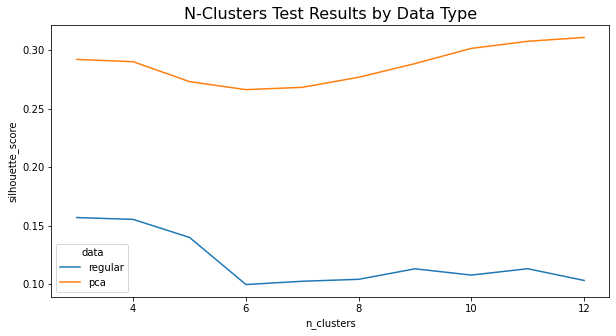

In [203]:
plt.figure(figsize = (10,5))

sns.lineplot(x = km_tests['n_clusters'], y = km_tests['silhouette_score'], hue = km_tests['data']);
plt.title('N-Clusters Test Results by Data Type', fontsize = 16);

In [204]:
def sort_album(album, model):
    
    # creating dataframe of cluster centers and their coordinates
    centroids_df = pd.DataFrame(model.cluster_centers_, 
                                columns = [f'PCA {i}' for i in range(1, len(pd.DataFrame(model.cluster_centers_).columns) + 1)],
                                index = [f'Cluster {i}' for i in range(1, len(pd.DataFrame(model.cluster_centers_).index) + 1)])
    
    # finding cosine similarity between cluster centers and album tracks (pca data) then creating dataframe
    similarity_df = pd.DataFrame(cosine_similarity(np.array(album_tracks_pca), model.cluster_centers_), index = album['track'], columns = centroids_df.index)
    
    # finding mean value of cosine similarities for each cluster, creating dataframe, and sorting values by decsending order
    optimal_cluster_df = pd.DataFrame(similarity_df.mean()).rename(columns = {0:'mean_cosine_sim'}).sort_values(by = 'mean_cosine_sim', ascending = False)
    
    # extract optimal cluster column (highest average cosine sim)
    song_scores = similarity_df[[optimal_cluster_df.index[0]]]
    column_name = list(song_scores.columns)[0]
    song_scores.rename(columns = {column_name: f'optimal_k ({column_name})'}, inplace = True)
    
    album = album.set_index('track')
    
    # merge scores on to album dataframe and sort songs by similarity scores
    sorted_album = pd.concat([album, song_scores], axis = 1).sort_values(by = song_scores.columns[0], ascending = False)

    return centroids_df, similarity_df, optimal_cluster_df, sorted_album

In [205]:
centroids_df, similarity_df, optimal_cluster_df, sorted_album = sort_album(album, model)

/Users/azizmaredia/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [206]:
centroids_df

,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8
Cluster 1,-0.030394,0.410343,0.102822,0.385884,0.876348,0.183425,0.181008,0.388150
Cluster 2,-0.081510,0.760597,0.049403,-0.312501,0.202072,-0.095210,-0.202219,-0.020742
Cluster 3,-0.018015,0.548616,-0.697450,0.319133,0.119270,0.027851,-0.243050,-0.028663
Cluster 4,1.349496,-0.280161,0.478953,-0.353824,-0.086503,-0.008285,-0.220643,0.088820
Cluster 5,-0.054752,0.824561,0.625152,0.602186,-0.451403,0.073120,0.148024,-0.054016
Cluster 6,-0.932677,-0.094605,0.055753,-0.611113,-0.121929,0.058362,0.090375,0.042051
Cluster 7,-0.862928,-0.299070,-0.704950,0.049900,-0.213396,0.012669,0.019717,0.043658
Cluster 8,-0.729996,-0.619140,0.621484,-0.089029,0.116556,-0.046164,-0.006588,-0.033672
Cluster 9,0.856405,-0.345515,0.040418,0.274393,0.328691,-0.175554,0.605438,-0.290336
Cluster 10,1.489627,-0.605093,-0.249720,0.239738,-0.174001,0.169179,-0.192725,0.204750


In [207]:
similarity_df

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
track,,,,,,,,,,,,
Beautiful Trip,-0.330146,-0.180172,0.348062,-0.754989,-0.356704,0.535143,0.963061,0.213468,-0.477332,-0.427754,-0.178335,0.640666
Tequila Shots,-0.194240,-0.289789,0.238667,-0.750991,-0.360304,0.583982,0.985419,0.301340,-0.527320,-0.395250,-0.282726,0.702779
Another Day,-0.226075,-0.251071,0.250571,-0.770814,-0.399277,0.604194,0.988950,0.330301,-0.516675,-0.440430,-0.277294,0.714095
She Knows This,-0.186493,-0.235988,0.248756,-0.708422,-0.396824,0.585719,0.961070,0.298349,-0.586487,-0.378405,-0.294467,0.679804
Dive,-0.196696,-0.224799,0.234783,-0.756888,-0.370901,0.616537,0.976382,0.329266,-0.565595,-0.443335,-0.309704,0.692909
Damaged,-0.234404,0.137879,-0.258229,-0.520006,-0.282597,0.935780,0.596615,0.653900,-0.712341,-0.702935,-0.405836,0.347996
Heaven On Earth,-0.310917,0.210849,-0.260933,-0.519334,-0.237914,0.915604,0.527369,0.660305,-0.624563,-0.768888,-0.366751,0.301496
Show Out (with Skepta & Pop Smoke),-0.159953,0.056341,-0.239876,-0.476017,-0.221401,0.872996,0.511372,0.578139,-0.627735,-0.601836,-0.304190,0.246316
"Solo Dolo, Pt. III",-0.255512,-0.281169,0.224635,-0.746970,-0.379822,0.599725,0.988548,0.325791,-0.527026,-0.411935,-0.276398,0.714268


In [208]:
optimal_cluster_df

,mean_cosine_sim
Cluster 7,0.834193
Cluster 6,0.706530
Cluster 12,0.552853
Cluster 8,0.413374
Cluster 3,0.079514
Cluster 2,-0.113189
Cluster 1,-0.219535
Cluster 11,-0.305922
Cluster 5,-0.321451
Cluster 10,-0.519760


In [209]:
sorted_album

,track_id,duration_ms,spotify_link,preview,optimal_k (Cluster 7)
track,,,,,
Sept. 16,3Uw2se3aQU1UFrpRBvBnB4,249040,https://open.spotify.com/track/3Uw2se3aQU1UFrp...,https://p.scdn.co/mp3-preview/62578afedb81632e...,0.991660
Sad People,4nuAslShoN77tq12fzwjUq,176027,https://open.spotify.com/track/4nuAslShoN77tq1...,https://p.scdn.co/mp3-preview/a2e8a2ffade8b892...,0.990274
Another Day,6myUpr3GDR80Dg3zqNTmmG,199787,https://open.spotify.com/track/6myUpr3GDR80Dg3...,https://p.scdn.co/mp3-preview/0270d8150fcbd742...,0.988950
"Solo Dolo, Pt. III",27oVCAziETRbNuo5A8LNpg,242267,https://open.spotify.com/track/27oVCAziETRbNuo...,https://p.scdn.co/mp3-preview/c461629a7f1acf31...,0.988548
Tequila Shots,30KctD1WsHKTIYczXjip5a,193293,https://open.spotify.com/track/30KctD1WsHKTIYc...,https://p.scdn.co/mp3-preview/eea2485b714dffab...,0.985419
Dive,7Hc3YL8oDiAzbiAW32KXrw,148707,https://open.spotify.com/track/7Hc3YL8oDiAzbiA...,https://p.scdn.co/mp3-preview/89e0c1d79d7d17f4...,0.976382
Rockstar Knights (with Trippie Redd),4J9SI7do4KOEsCexqEbjmR,231467,https://open.spotify.com/track/4J9SI7do4KOEsCe...,https://p.scdn.co/mp3-preview/d0610339176bd8c2...,0.964472
Elsie's Baby Boy (flashback),6jiwr6xTHqjdun5d3cEwXV,219213,https://open.spotify.com/track/6jiwr6xTHqjdun5...,https://p.scdn.co/mp3-preview/62530a94d72e2613...,0.963610
Beautiful Trip,4IIuCotvqijraSdnVLaFnM,37013,https://open.spotify.com/track/4IIuCotvqijraSd...,https://p.scdn.co/mp3-preview/05edcc06fc085a58...,0.963061


In [210]:
x = optimal_cluster_df['mean_cosine_sim'].index[-1]
least_similar = pd.DataFrame(similarity_df[x].sort_values(ascending = False).index).rename(columns = {'track':f'Least Similar ({x})'})

In [211]:
x3 = optimal_cluster_df['mean_cosine_sim'].index[0]
most_similar = pd.DataFrame(similarity_df[x3].sort_values(ascending = False).index).rename(columns = {'track':f'Most Similar ({x3})'})

In [212]:
pd.concat([most_similar, least_similar], axis = 1)

,Most Similar (Cluster 7),Least Similar (Cluster 4)
0,Sept. 16,Lovin’ Me (feat. Phoebe Bridgers)
1,Sad People,Show Out (with Skepta & Pop Smoke)
2,Another Day,Lord I Know
3,"Solo Dolo, Pt. III",Heaven On Earth
4,Tequila Shots,Damaged
5,Dive,4 Da Kidz
6,Rockstar Knights (with Trippie Redd),She Knows This
7,Elsie's Baby Boy (flashback),Rockstar Knights (with Trippie Redd)
8,Beautiful Trip,The Pale Moonlight
9,She Knows This,The Void


In [ ]:
tracks = pd.concat([tracks, pd.DataFrame(model.labels_)], axis = 1).rename(columns = {0:'cluster'})
cluster_tracks = tracks.groupby(by = 'cluster').mean()[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']].reset_index(level = 0)

In [108]:
cluster_tracks

,cluster,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence
0,0.0,0.611960,0.597594,0.088839,0.228011,0.207959,0.186544,0.428502
1,1.0,0.674725,0.628702,0.219873,0.192537,0.024021,0.221115,0.432982
2,2.0,0.610441,0.764366,0.103759,0.074765,0.086897,0.220858,0.423443
3,3.0,0.736060,0.630006,0.182371,0.141167,0.007322,0.177337,0.452810
4,4.0,0.706198,0.747099,0.078543,0.075833,0.273110,0.184470,0.391616
5,5.0,0.604557,0.657474,0.051187,0.256387,0.083636,0.178244,0.602412
6,6.0,0.636859,0.782313,0.085486,0.071917,0.205227,0.208041,0.368362
7,7.0,0.607427,0.723977,0.069056,0.125119,0.175445,0.190514,0.370108
8,8.0,0.702671,0.661947,0.239834,0.173702,0.012767,0.241634,0.444724
9,9.0,0.634333,0.622120,0.086384,0.208673,0.323136,0.190190,0.448233


In [101]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi, ceil
 
def make_radar(row, title, color, dframe, num_clusters):
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(4, ceil(num_clusters/4), row+1, polar = True)
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(1)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)

    # Ind1
    values=dframe.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=12, color='white', y=1.06)

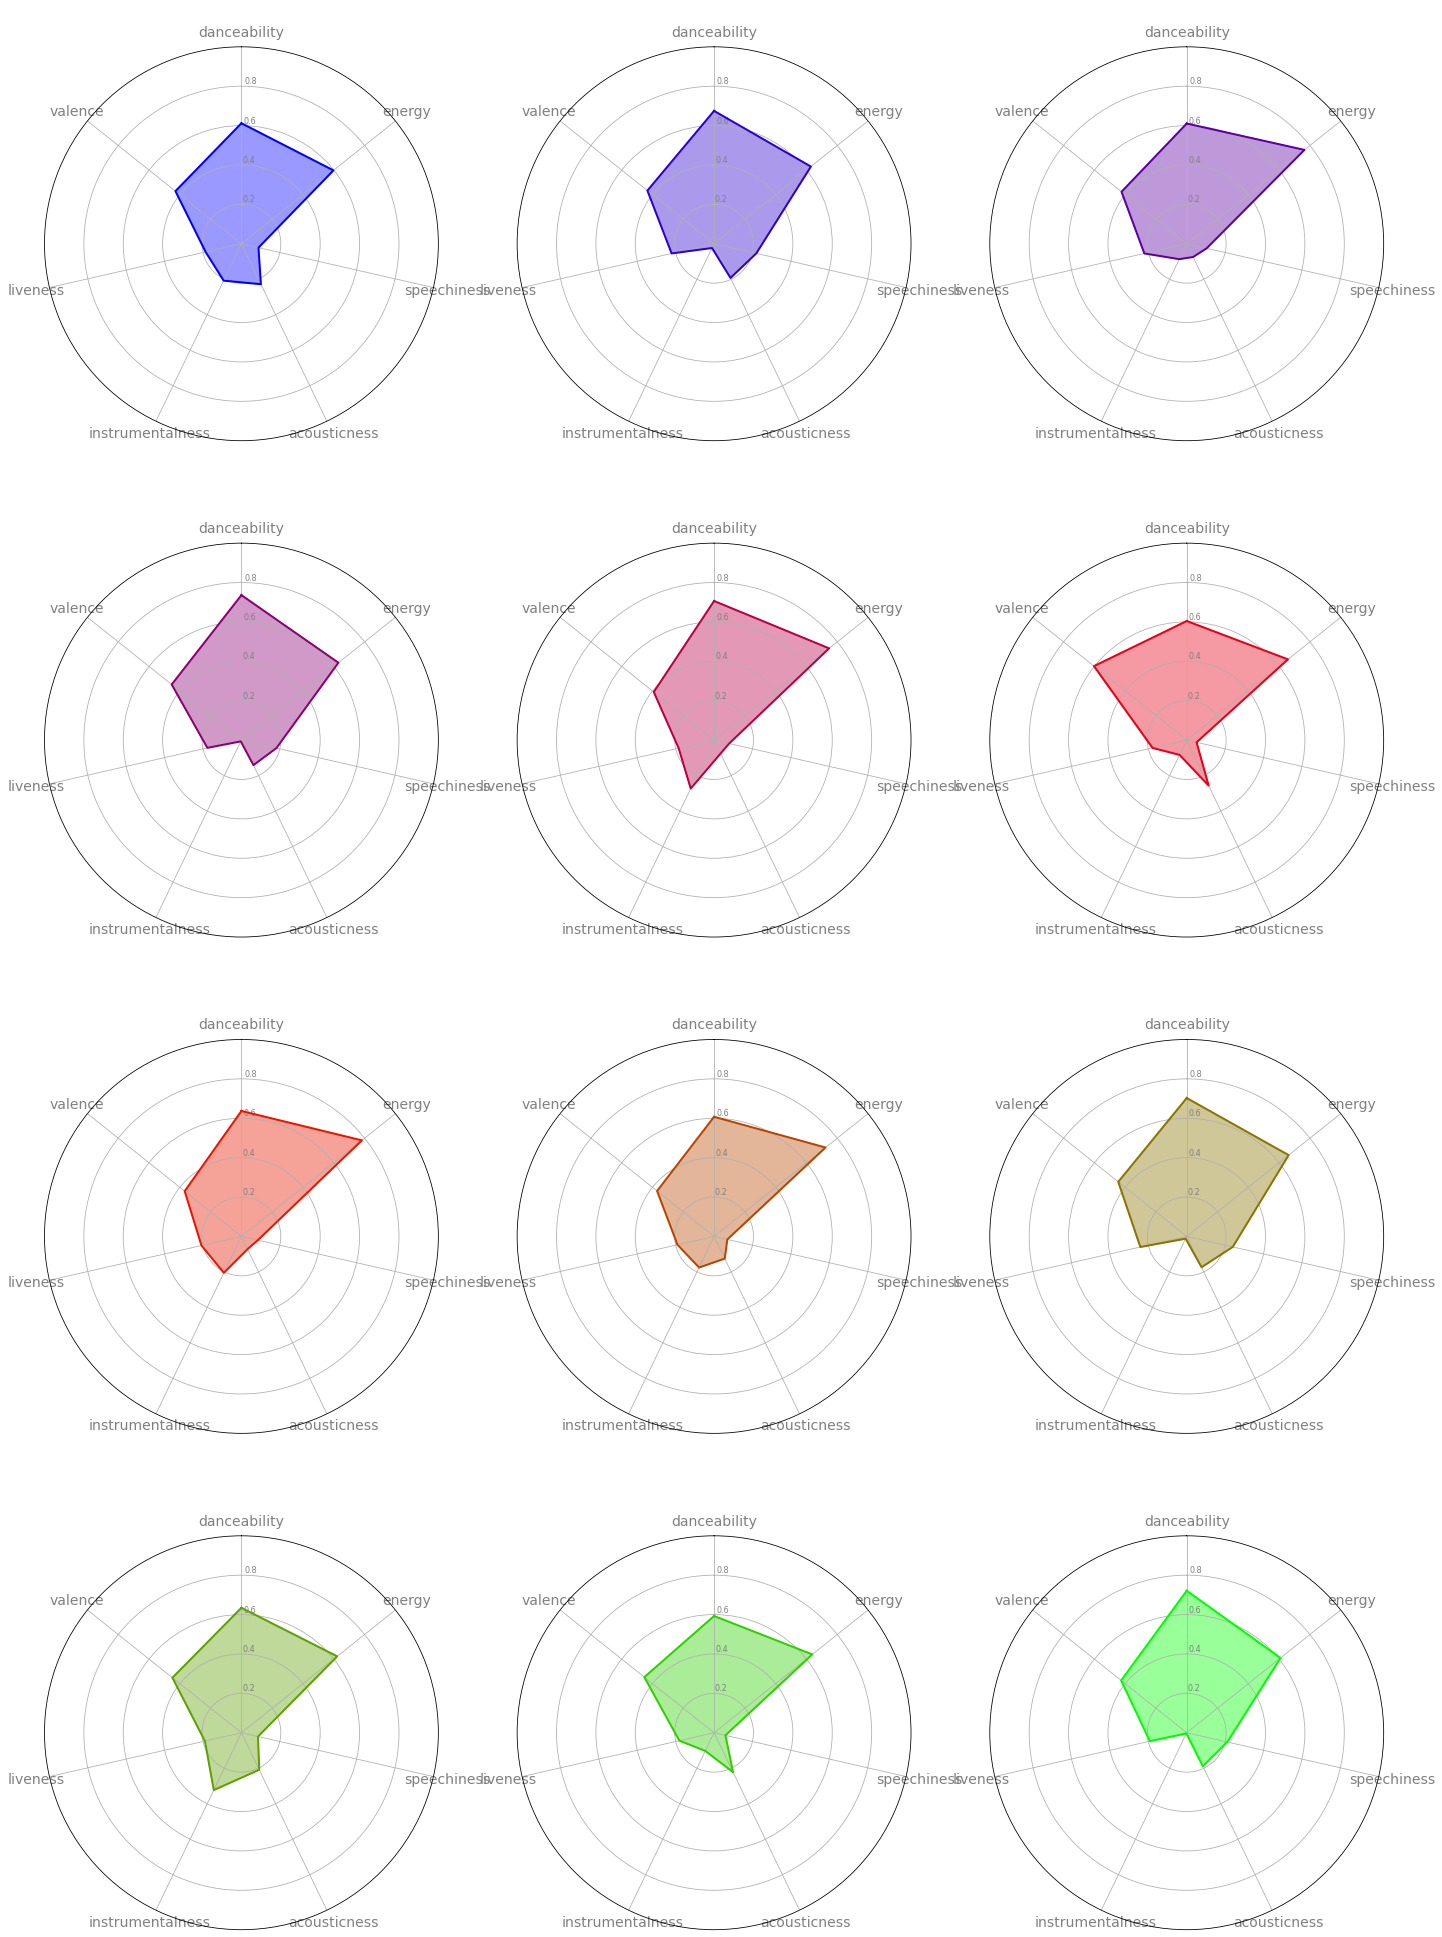

In [102]:
# initialize the figure
plt.figure(figsize=(24,35))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("brg", len(cluster_tracks.index))

# Loop to plot
for row in range(0, len(cluster_tracks.index)):
    make_radar(row = row, 
               title = 'Cluster ' + str(cluster_tracks['cluster'][row]), 
               color = my_palette(row), 
               dframe = cluster_tracks, 
               num_clusters = len(cluster_tracks.index))

In [109]:
cluster_genres = tracks.groupby(by = 'cluster').mean()[[i for i in tracks.columns if 'genre' in i]].T

top_genres_dict = {}

for i in cluster_genres.columns:
    top_genres = cluster_genres[i].sort_values(ascending = False)[:3].index
    top_genres_dict[i] = top_genres

pd.DataFrame(top_genres_dict).T

""
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
